In [26]:
from IPython.display import display, Markdown
import json

path = "../"
path += "exp-10-09_150151-LLaMEA-gemini-2.5-flash-pop1-5"

with open(path + "/conversationlog.jsonl") as f:
    lines = f.readlines()
    for index,line in enumerate(lines):
        data = json.loads(line)
        display(Markdown(f"# {index//2 + 1} {data["role"]}"))
        display(Markdown(data["content"]))
        # fitness_deez.append(data["fitness"])

# 1 client

You are a highly skilled computer scientist in the field of natural computing. Your task is to design novel metaheuristic algorithms to solve black box optimization problems.
    The optimization algorithm should handle a wide range of tasks, which is evaluated on the BBOB test suite of 24 noiseless functions. Your task is to write the optimization algorithm in Python code. The code should contain an `__init__(self, budget, dim)` function and the function `def __call__(self, func)`, which should optimize the black box function `func` using `self.budget` function evaluations.
    The func() can only be called as many times as the budget allows, not more. Each of the optimization functions has a search space between -5.0 (lower bound) and 5.0 (upper bound). The dimensionality can be varied.
    Give an excellent and novel heuristic algorithm to solve this task and also give it a one-line description with the main idea.
    
An example of such code (a simple random search), is as follows:
```
import numpy as np

class RandomSearch:
    def __init__(self, budget=10000, dim=10):
        self.budget = budget
        self.dim = dim
        self.f_opt = np.inf
        self.x_opt = None

    def __call__(self, func):
        for i in range(self.budget):
            x = np.random.uniform(func.bounds.lb, func.bounds.ub)

            f = func(x)
            if f < self.f_opt:
                self.f_opt = f
                self.x_opt = x

        return self.f_opt, self.x_opt
```

Provide the Python code and a one-line description with the main idea (without enters). Give the response in the format:
# Description: <short-description>
# Code:
```python
<code>
```


# 1 gemini-2.5-flash

# Description: Employs adaptive differential evolution (JADE-inspired) with a 'current-to-pbest' mutation strategy, an external archive of inferior solutions for diversity, and self-adaptive parameter learning.
# Code:
```python
import numpy as np

class SADEA: # Self-Adaptive Differential Evolution with Archive
    def __init__(self, budget=10000, dim=10):
        self.budget = budget
        self.dim = dim
        self.f_opt = np.inf
        self.x_opt = None

    def __call__(self, func):
        lb = func.bounds.lb
        ub = func.bounds.ub

        # Parameters
        # Population size scaling heuristic: balances exploration and computational cost.
        # This formula leads to pop_size of 4 for D=2, 47 for D=10, 294 for D=40.
        pop_size = max(4, int(self.dim * np.log(self.dim + 1) * 2))
        
        archive_size = pop_size # Archive size typically equals pop_size
        p_factor = 0.1 # Parameter for 'pbest' selection (top p% individuals)
        learning_rate_c = 0.1 # For updating mu_F and mu_CR (usually 0.1 or 0.2)

        # Initialize population
        pop = np.random.uniform(lb, ub, size=(pop_size, self.dim))
        fitness = np.full(pop_size, np.inf)

        # Evaluate initial population and update global best
        for i in range(pop_size):
            if self.budget <= 0:
                break
            f_val = func(pop[i])
            self.budget -= 1
            fitness[i] = f_val
            if f_val < self.f_opt:
                self.f_opt = f_val
                self.x_opt = pop[i].copy()

        # Initialize archive of replaced individuals
        archive = []

        # Initialize adaptive parameters (means of F and CR)
        # These will be updated based on successful mutation/crossover operations
        mu_F = 0.5 # Mean for Cauchy distribution to generate F
        mu_CR = 0.5 # Mean for Normal distribution to generate CR

        # Main optimization loop
        while self.budget > 0:
            # Sort population to easily select 'pbest' individuals
            # This allows efficient selection of top performers without re-sorting entire array
            sorted_indices = np.argsort(fitness)
            
            successful_F = [] # Store F values of successful trials for parameter adaptation
            successful_CR = [] # Store CR values of successful trials for parameter adaptation
            
            new_pop = np.empty_like(pop)
            new_fitness = np.full(pop_size, np.inf)

            for i in range(pop_size):
                if self.budget <= 0:
                    break

                # Generate F_i and CR_i for current individual based on learned means
                # F from Cauchy, clipped to [0,1] and positive
                F_i = np.random.standard_cauchy() * 0.1 + mu_F
                F_i = np.clip(F_i, 0.0, 1.0) # F must be in [0, 1]

                # CR from Normal, clipped to [0,1]
                CR_i = np.random.normal(loc=mu_CR, scale=0.1)
                CR_i = np.clip(CR_i, 0.0, 1.0) # CR must be in [0, 1]

                # --- Mutation Strategy: DE/current-to-pbest/1 with archive ---
                # This strategy balances exploitation (via x_pbest) and exploration (via x_r1, x_r2)
                # and uses the archive for diversity.
                x_i = pop[i]

                # Select 'pbest' from the top p% of current population (by sorted_indices)
                num_pbest_candidates = max(1, int(pop_size * p_factor))
                pbest_original_idx = sorted_indices[np.random.randint(num_pbest_candidates)]
                x_pbest = pop[pbest_original_idx]

                # Select r1 from current population (must be distinct from i and pbest_original_idx)
                candidates_r1_indices = [idx for idx in range(pop_size) if idx != i and idx != pbest_original_idx]
                
                # Fallback for very small populations where distinct indices might be hard to find
                if not candidates_r1_indices: 
                    candidates_r1_indices = [idx for idx in range(pop_size) if idx != i]
                
                r1_idx = np.random.choice(candidates_r1_indices)
                x_r1 = pop[r1_idx]

                # Select r2 from the union of current population and archive
                # This explicitly injects diversity from previously replaced solutions
                combined_pool = list(pop) + archive
                # Ensure combined_pool has elements. If archive is empty, x_r2 effectively comes from pop.
                if not combined_pool: 
                    x_r2 = np.random.uniform(lb, ub, self.dim) # Emergency random if pool is empty
                else:
                    x_r2 = combined_pool[np.random.randint(len(combined_pool))]

                # Construct mutant vector
                V_i = x_i + F_i * (x_pbest - x_i) + F_i * (x_r1 - x_r2)

                # --- Crossover (Binomial) ---
                U_i = np.copy(x_i)
                j_rand = np.random.randint(self.dim) # Ensure at least one dimension is from V_i to prevent U_i == x_i
                for j in range(self.dim):
                    if np.random.rand() < CR_i or j == j_rand:
                        U_i[j] = V_i[j]

                # Boundary handling: clip trial vector to search space [-5, 5]
                U_i = np.clip(U_i, lb, ub)

                # --- Evaluation and Selection ---
                f_U_i = func(U_i)
                self.budget -= 1

                if f_U_i < self.f_opt:
                    self.f_opt = f_U_i
                    self.x_opt = U_i.copy()

                if f_U_i <= fitness[i]: # If trial vector is better or equal
                    new_pop[i] = U_i # Replace current individual
                    new_fitness[i] = f_U_i
                    
                    # Add the *old* individual (pop[i]) to the archive
                    archive.append(pop[i].copy())
                    if len(archive) > archive_size:
                        archive.pop(np.random.randint(len(archive))) # Remove a random old individual to maintain archive size
                    
                    # Store F_i and CR_i for successful adaptation
                    successful_F.append(F_i)
                    successful_CR.append(CR_i)
                else: # If trial vector is worse
                    new_pop[i] = pop[i] # Keep current individual
                    new_fitness[i] = fitness[i]
            
            # Update population for next generation
            pop = new_pop
            fitness = new_fitness

            # --- Parameter Adaptation (JADE-style) ---
            # Update mu_F and mu_CR based on successful parameters
            if successful_F:
                # Update mu_F using the Lehmer mean (more robust for F)
                mu_F = (1 - learning_rate_c) * mu_F + learning_rate_c * (np.sum(np.array(successful_F)**2) / np.sum(successful_F))
            
            if successful_CR:
                # Update mu_CR using the arithmetic mean
                mu_CR = (1 - learning_rate_c) * mu_CR + learning_rate_c * np.mean(successful_CR)

            # Ensure mu_F and mu_CR don't become too small or large
            mu_F = np.clip(mu_F, 0.05, 1.0) 
            mu_CR = np.clip(mu_CR, 0.05, 1.0) 

        return self.f_opt, self.x_opt
```

# 2 client

You are a highly skilled computer scientist in the field of natural computing. Your task is to design novel metaheuristic algorithms to solve black box optimization problems.
    The optimization algorithm should handle a wide range of tasks, which is evaluated on the BBOB test suite of 24 noiseless functions. Your task is to write the optimization algorithm in Python code. The code should contain an `__init__(self, budget, dim)` function and the function `def __call__(self, func)`, which should optimize the black box function `func` using `self.budget` function evaluations.
    The func() can only be called as many times as the budget allows, not more. Each of the optimization functions has a search space between -5.0 (lower bound) and 5.0 (upper bound). The dimensionality can be varied.
    Give an excellent and novel heuristic algorithm to solve this task and also give it a one-line description with the main idea.
    
The current population of algorithms already evaluated (name, description, score) is:
SADEA: Employs adaptive differential evolution (JADE-inspired) with a 'current-to-pbest' mutation strategy, an external archive of inferior solutions for diversity, and self-adaptive parameter learning. (Score: 0.2900111426661414)

The selected solution to update is:
Employs adaptive differential evolution (JADE-inspired) with a 'current-to-pbest' mutation strategy, an external archive of inferior solutions for diversity, and self-adaptive parameter learning.

With code:

```python
import numpy as np

class SADEA: # Self-Adaptive Differential Evolution with Archive
    def __init__(self, budget=10000, dim=10):
        self.budget = budget
        self.dim = dim
        self.f_opt = np.inf
        self.x_opt = None

    def __call__(self, func):
        lb = func.bounds.lb
        ub = func.bounds.ub

        # Parameters
        # Population size scaling heuristic: balances exploration and computational cost.
        # This formula leads to pop_size of 4 for D=2, 47 for D=10, 294 for D=40.
        pop_size = max(4, int(self.dim * np.log(self.dim + 1) * 2))
        
        archive_size = pop_size # Archive size typically equals pop_size
        p_factor = 0.1 # Parameter for 'pbest' selection (top p% individuals)
        learning_rate_c = 0.1 # For updating mu_F and mu_CR (usually 0.1 or 0.2)

        # Initialize population
        pop = np.random.uniform(lb, ub, size=(pop_size, self.dim))
        fitness = np.full(pop_size, np.inf)

        # Evaluate initial population and update global best
        for i in range(pop_size):
            if self.budget <= 0:
                break
            f_val = func(pop[i])
            self.budget -= 1
            fitness[i] = f_val
            if f_val < self.f_opt:
                self.f_opt = f_val
                self.x_opt = pop[i].copy()

        # Initialize archive of replaced individuals
        archive = []

        # Initialize adaptive parameters (means of F and CR)
        # These will be updated based on successful mutation/crossover operations
        mu_F = 0.5 # Mean for Cauchy distribution to generate F
        mu_CR = 0.5 # Mean for Normal distribution to generate CR

        # Main optimization loop
        while self.budget > 0:
            # Sort population to easily select 'pbest' individuals
            # This allows efficient selection of top performers without re-sorting entire array
            sorted_indices = np.argsort(fitness)
            
            successful_F = [] # Store F values of successful trials for parameter adaptation
            successful_CR = [] # Store CR values of successful trials for parameter adaptation
            
            new_pop = np.empty_like(pop)
            new_fitness = np.full(pop_size, np.inf)

            for i in range(pop_size):
                if self.budget <= 0:
                    break

                # Generate F_i and CR_i for current individual based on learned means
                # F from Cauchy, clipped to [0,1] and positive
                F_i = np.random.standard_cauchy() * 0.1 + mu_F
                F_i = np.clip(F_i, 0.0, 1.0) # F must be in [0, 1]

                # CR from Normal, clipped to [0,1]
                CR_i = np.random.normal(loc=mu_CR, scale=0.1)
                CR_i = np.clip(CR_i, 0.0, 1.0) # CR must be in [0, 1]

                # --- Mutation Strategy: DE/current-to-pbest/1 with archive ---
                # This strategy balances exploitation (via x_pbest) and exploration (via x_r1, x_r2)
                # and uses the archive for diversity.
                x_i = pop[i]

                # Select 'pbest' from the top p% of current population (by sorted_indices)
                num_pbest_candidates = max(1, int(pop_size * p_factor))
                pbest_original_idx = sorted_indices[np.random.randint(num_pbest_candidates)]
                x_pbest = pop[pbest_original_idx]

                # Select r1 from current population (must be distinct from i and pbest_original_idx)
                candidates_r1_indices = [idx for idx in range(pop_size) if idx != i and idx != pbest_original_idx]
                
                # Fallback for very small populations where distinct indices might be hard to find
                if not candidates_r1_indices: 
                    candidates_r1_indices = [idx for idx in range(pop_size) if idx != i]
                
                r1_idx = np.random.choice(candidates_r1_indices)
                x_r1 = pop[r1_idx]

                # Select r2 from the union of current population and archive
                # This explicitly injects diversity from previously replaced solutions
                combined_pool = list(pop) + archive
                # Ensure combined_pool has elements. If archive is empty, x_r2 effectively comes from pop.
                if not combined_pool: 
                    x_r2 = np.random.uniform(lb, ub, self.dim) # Emergency random if pool is empty
                else:
                    x_r2 = combined_pool[np.random.randint(len(combined_pool))]

                # Construct mutant vector
                V_i = x_i + F_i * (x_pbest - x_i) + F_i * (x_r1 - x_r2)

                # --- Crossover (Binomial) ---
                U_i = np.copy(x_i)
                j_rand = np.random.randint(self.dim) # Ensure at least one dimension is from V_i to prevent U_i == x_i
                for j in range(self.dim):
                    if np.random.rand() < CR_i or j == j_rand:
                        U_i[j] = V_i[j]

                # Boundary handling: clip trial vector to search space [-5, 5]
                U_i = np.clip(U_i, lb, ub)

                # --- Evaluation and Selection ---
                f_U_i = func(U_i)
                self.budget -= 1

                if f_U_i < self.f_opt:
                    self.f_opt = f_U_i
                    self.x_opt = U_i.copy()

                if f_U_i <= fitness[i]: # If trial vector is better or equal
                    new_pop[i] = U_i # Replace current individual
                    new_fitness[i] = f_U_i
                    
                    # Add the *old* individual (pop[i]) to the archive
                    archive.append(pop[i].copy())
                    if len(archive) > archive_size:
                        archive.pop(np.random.randint(len(archive))) # Remove a random old individual to maintain archive size
                    
                    # Store F_i and CR_i for successful adaptation
                    successful_F.append(F_i)
                    successful_CR.append(CR_i)
                else: # If trial vector is worse
                    new_pop[i] = pop[i] # Keep current individual
                    new_fitness[i] = fitness[i]
            
            # Update population for next generation
            pop = new_pop
            fitness = new_fitness

            # --- Parameter Adaptation (JADE-style) ---
            # Update mu_F and mu_CR based on successful parameters
            if successful_F:
                # Update mu_F using the Lehmer mean (more robust for F)
                mu_F = (1 - learning_rate_c) * mu_F + learning_rate_c * (np.sum(np.array(successful_F)**2) / np.sum(successful_F))
            
            if successful_CR:
                # Update mu_CR using the arithmetic mean
                mu_CR = (1 - learning_rate_c) * mu_CR + learning_rate_c * np.mean(successful_CR)

            # Ensure mu_F and mu_CR don't become too small or large
            mu_F = np.clip(mu_F, 0.05, 1.0) 
            mu_CR = np.clip(mu_CR, 0.05, 1.0) 

        return self.f_opt, self.x_opt
```


Feedback:

The algorithm SADEA got an average Area over the convergence curve (AOCC, 1.0 is the best) score of 0.29 with standard deviation 0.31.



Refine the strategy of the selected solution to improve it.


        ---
You MUST use the exact SEARCH/REPLACE diff format shown below to indicate changes:
```
<<<<<<< SEARCH
# Original code to find and replace (must match exactly)
=======
# New replacement code
>>>>>>> REPLACE
```

Example of valid diff format:
```
<<<<<<< SEARCH
for i in range(m):
    for j in range(p):
        for k in range(n):
            C[i, j] += A[i, k] * B[k, j]
=======
# Reorder loops for better memory access pattern
for i in range(m):
    for k in range(n):
        for j in range(p):
            C[i, j] += A[i, k] * B[k, j]
>>>>>>> REPLACE
```



# 2 gemini-2.5-flash

One-line description: Employs a history-based self-adaptive differential evolution (SHADE-inspired) with 'current-to-pbest/1' mutation, an external archive, and linear population reduction to balance exploration and exploitation.

The refinement focuses on incorporating advanced features from the SHADE (Success-History-based Adaptive Differential Evolution) algorithm, which has demonstrated state-of-the-art performance on BBOB benchmarks. Key improvements include:

1.  **History-based Parameter Adaptation**: Instead of using a single `mu_F` and `mu_CR` updated by a learning rate (JADE style), SHADE maintains a history of `H` successful `F` and `CR` values. For each individual, `F_i` and `CR_i` are generated by sampling a mean from this history. The history is then updated with the weighted means of `F` and `CR` from the *current* successful trials. This provides a more robust and stable adaptation.
2.  **Linear Population Reduction (L-SHADE inspired)**: The population size (`pop_size`) is dynamically reduced from an initial size to a minimum size over the course of the optimization, proportional to the number of function evaluations used. This strategy helps to improve convergence speed on unimodal functions in later stages while maintaining diversity in earlier stages. When the population is reduced, the worst individuals are pruned.
3.  **Refined `F_i` Generation**: The `F_i` value is regenerated if it happens to be non-positive, ensuring it remains a valid scaling factor before being clipped to `[0,1]`.

These enhancements are expected to boost the algorithm's performance on the BBOB suite by improving the balance between exploration and exploitation and adapting more effectively to different problem landscapes and optimization stages.

```python
<<<<<<< SEARCH
class SADEA: # Self-Adaptive Differential Evolution with Archive
    def __init__(self, budget=10000, dim=10):
        self.budget = budget
        self.dim = dim
        self.f_opt = np.inf
        self.x_opt = None

    def __call__(self, func):
        lb = func.bounds.lb
        ub = func.bounds.ub

        # Parameters
        # Population size scaling heuristic: balances exploration and computational cost.
        # This formula leads to pop_size of 4 for D=2, 47 for D=10, 294 for D=40.
        pop_size = max(4, int(self.dim * np.log(self.dim + 1) * 2))
        
        archive_size = pop_size # Archive size typically equals pop_size
        p_factor = 0.1 # Parameter for 'pbest' selection (top p% individuals)
        learning_rate_c = 0.1 # For updating mu_F and mu_CR (usually 0.1 or 0.2)

        # Initialize population
        pop = np.random.uniform(lb, ub, size=(pop_size, self.dim))
        fitness = np.full(pop_size, np.inf)

        # Evaluate initial population and update global best
        for i in range(pop_size):
            if self.budget <= 0:
                break
            f_val = func(pop[i])
            self.budget -= 1
            fitness[i] = f_val
            if f_val < self.f_opt:
                self.f_opt = f_val
                self.x_opt = pop[i].copy()

        # Initialize archive of replaced individuals
        archive = []

        # Initialize adaptive parameters (means of F and CR)
        # These will be updated based on successful mutation/crossover operations
        mu_F = 0.5 # Mean for Cauchy distribution to generate F
        mu_CR = 0.5 # Mean for Normal distribution to generate CR

        # Main optimization loop
        while self.budget > 0:
            # Sort population to easily select 'pbest' individuals
            # This allows efficient selection of top performers without re-sorting entire array
            sorted_indices = np.argsort(fitness)
            
            successful_F = [] # Store F values of successful trials for parameter adaptation
            successful_CR = [] # Store CR values of successful trials for parameter adaptation
            
            new_pop = np.empty_like(pop)
            new_fitness = np.full(pop_size, np.inf)

            for i in range(pop_size):
                if self.budget <= 0:
                    break

                # Generate F_i and CR_i for current individual based on learned means
                # F from Cauchy, clipped to [0,1] and positive
                F_i = np.random.standard_cauchy() * 0.1 + mu_F
                F_i = np.clip(F_i, 0.0, 1.0) # F must be in [0, 1]

                # CR from Normal, clipped to [0,1]
                CR_i = np.random.normal(loc=mu_CR, scale=0.1)
                CR_i = np.clip(CR_i, 0.0, 1.0) # CR must be in [0, 1]

                # --- Mutation Strategy: DE/current-to-pbest/1 with archive ---
                # This strategy balances exploitation (via x_pbest) and exploration (via x_r1, x_r2)
                # and uses the archive for diversity.
                x_i = pop[i]

                # Select 'pbest' from the top p% of current population (by sorted_indices)
                num_pbest_candidates = max(1, int(pop_size * p_factor))
                pbest_original_idx = sorted_indices[np.random.randint(num_pbest_candidates)]
                x_pbest = pop[pbest_original_idx]

                # Select r1 from current population (must be distinct from i and pbest_original_idx)
                candidates_r1_indices = [idx for idx in range(pop_size) if idx != i and idx != pbest_original_idx]
                
                # Fallback for very small populations where distinct indices might be hard to find
                if not candidates_r1_indices: 
                    candidates_r1_indices = [idx for idx in range(pop_size) if idx != i]
                
                r1_idx = np.random.choice(candidates_r1_indices)
                x_r1 = pop[r1_idx]

                # Select r2 from the union of current population and archive
                # This explicitly injects diversity from previously replaced solutions
                combined_pool = list(pop) + archive
                # Ensure combined_pool has elements. If archive is empty, x_r2 effectively comes from pop.
                if not combined_pool: 
                    x_r2 = np.random.uniform(lb, ub, self.dim) # Emergency random if pool is empty
                else:
                    x_r2 = combined_pool[np.random.randint(len(combined_pool))]

                # Construct mutant vector
                V_i = x_i + F_i * (x_pbest - x_i) + F_i * (x_r1 - x_r2)

                # --- Crossover (Binomial) ---
                U_i = np.copy(x_i)
                j_rand = np.random.randint(self.dim) # Ensure at least one dimension is from V_i to prevent U_i == x_i
                for j in range(self.dim):
                    if np.random.rand() < CR_i or j == j_rand:
                        U_i[j] = V_i[j]

                # Boundary handling: clip trial vector to search space [-5, 5]
                U_i = np.clip(U_i, lb, ub)

                # --- Evaluation and Selection ---
                f_U_i = func(U_i)
                self.budget -= 1

                if f_U_i < self.f_opt:
                    self.f_opt = f_U_i
                    self.x_opt = U_i.copy()

                if f_U_i <= fitness[i]: # If trial vector is better or equal
                    new_pop[i] = U_i # Replace current individual
                    new_fitness[i] = f_U_i
                    
                    # Add the *old* individual (pop[i]) to the archive
                    archive.append(pop[i].copy())
                    if len(archive) > archive_size:
                        archive.pop(np.random.randint(len(archive))) # Remove a random old individual to maintain archive size
                    
                    # Store F_i and CR_i for successful adaptation
                    successful_F.append(F_i)
                    successful_CR.append(CR_i)
                else: # If trial vector is worse
                    new_pop[i] = pop[i] # Keep current individual
                    new_fitness[i] = fitness[i]
            
            # Update population for next generation
            pop = new_pop
            fitness = new_fitness

            # --- Parameter Adaptation (JADE-style) ---
            # Update mu_F and mu_CR based on successful parameters
            if successful_F:
                # Update mu_F using the Lehmer mean (more robust for F)
                mu_F = (1 - learning_rate_c) * mu_F + learning_rate_c * (np.sum(np.array(successful_F)**2) / np.sum(successful_F))
            
            if successful_CR:
                # Update mu_CR using the arithmetic mean
                mu_CR = (1 - learning_rate_c) * mu_CR + learning_rate_c * np.mean(successful_CR)

            # Ensure mu_F and mu_CR don't become too small or large
            mu_F = np.clip(mu_F, 0.05, 1.0) 
            mu_CR = np.clip(mu_CR, 0.05, 1.0) 

        return self.f_opt, self.x_opt
=======
class SADEA: # Self-Adaptive Differential Evolution with Archive, History, and Population Reduction (SHADE-inspired)
    def __init__(self, budget=10000, dim=10):
        self.budget = budget
        self.dim = dim
        self.f_opt = np.inf
        self.x_opt = None

    def __call__(self, func):
        lb = func.bounds.lb
        ub = func.bounds.ub

        # Parameters
        # Population size scaling heuristic: balances exploration and computational cost.
        # This formula leads to pop_size of 4 for D=2, 47 for D=10, 294 for D=40.
        pop_size = max(4, int(self.dim * np.log(self.dim + 1) * 2))
        
        # --- NEW: Parameters for L-SHADE style population reduction ---
        initial_pop_size = pop_size # Store the initial pop_size
        pop_size_min = 4            # Minimum population size
        total_evals_at_start = self.budget # Store original budget for budget tracking
        
        archive_size = pop_size # Archive size typically equals pop_size
        p_factor = 0.1 # Parameter for 'pbest' selection (top p% individuals)

        # --- NEW: Parameters for SHADE-style history-based adaptation ---
        H = max(2, min(self.dim, 100)) # History size. Min 2 for dim=1, Max 100 for large dim.
        H_F = np.full(H, 0.5)  # Initialize all F in history to 0.5
        H_CR = np.full(H, 0.5) # Initialize all CR in history to 0.5
        history_idx = 0        # Pointer for updating history

        # Initialize population
        pop = np.random.uniform(lb, ub, size=(pop_size, self.dim))
        fitness = np.full(pop_size, np.inf)

        # Evaluate initial population and update global best
        for i in range(pop_size):
            if self.budget <= 0:
                break
            f_val = func(pop[i])
            self.budget -= 1
            fitness[i] = f_val
            if f_val < self.f_opt:
                self.f_opt = f_val
                self.x_opt = pop[i].copy()

        # Initialize archive of replaced individuals
        archive = []

        # Main optimization loop
        while self.budget > 0:
            # --- NEW: Population Size Adaptation (L-SHADE style) ---
            evals_spent = total_evals_at_start - self.budget
            
            # Calculate target population size based on remaining budget
            current_pop_size_target = round(initial_pop_size + (pop_size_min - initial_pop_size) / total_evals_at_start * evals_spent)
            current_pop_size_target = max(pop_size_min, current_pop_size_target) # Ensure minimum size

            # If target pop_size is smaller than current, reduce population
            if current_pop_size_target < pop_size:
                # Sort by fitness to keep the best individuals
                sorted_indices_for_pruning = np.argsort(fitness)
                
                pop = pop[sorted_indices_for_pruning[:current_pop_size_target]]
                fitness = fitness[sorted_indices_for_pruning[:current_pop_size_target]]
                pop_size = current_pop_size_target # Update the pop_size variable
                
                # Adjust archive size proportionally and prune if necessary
                archive_size = pop_size 
                while len(archive) > archive_size:
                    archive.pop(np.random.randint(len(archive))) # Remove a random old individual

            # Sort population to easily select 'pbest' individuals (needs to be done AFTER pop_size reduction)
            # This allows efficient selection of top performers without re-sorting entire array
            sorted_indices = np.argsort(fitness)
            
            successful_F = [] # Store F values of successful trials for parameter adaptation
            successful_CR = [] # Store CR values of successful trials for parameter adaptation
            
            # Allocate new_pop and new_fitness based on the current (possibly reduced) pop_size
            new_pop = np.empty_like(pop)
            new_fitness = np.full(pop_size, np.inf)

            for i in range(pop_size):
                if self.budget <= 0:
                    break

                # --- SHADE-style Parameter Generation ---
                # Select random index 'r' from the history to get mean F and CR
                r_idx = np.random.randint(H)
                
                # Generate F_i from Cauchy distribution, using H_F[r_idx] as mean
                F_i = np.random.standard_cauchy() * 0.1 + H_F[r_idx]
                # Ensure F_i is positive. Regenerate if F_i <= 0, then clip to [0,1].
                while F_i <= 0: 
                    F_i = np.random.standard_cauchy() * 0.1 + H_F[r_idx]
                F_i = np.clip(F_i, 0.0, 1.0) 

                # Generate CR_i from Normal distribution, using H_CR[r_idx] as mean
                CR_i = np.random.normal(loc=H_CR[r_idx], scale=0.1)
                CR_i = np.clip(CR_i, 0.0, 1.0) 

                # --- Mutation Strategy: DE/current-to-pbest/1 with archive ---
                # This strategy balances exploitation (via x_pbest) and exploration (via x_r1, x_r2)
                # and uses the archive for diversity.
                x_i = pop[i]

                # Select 'pbest' from the top p% of current population (by sorted_indices)
                num_pbest_candidates = max(1, int(pop_size * p_factor))
                pbest_original_idx = sorted_indices[np.random.randint(num_pbest_candidates)]
                x_pbest = pop[pbest_original_idx]

                # Select r1 from current population (must be distinct from i and pbest_original_idx)
                candidates_r1_indices = [idx for idx in range(pop_size) if idx != i and idx != pbest_original_idx]
                
                # Fallback for very small populations where distinct indices might be hard to find
                if not candidates_r1_indices: 
                    candidates_r1_indices = [idx for idx in range(pop_size) if idx != i]
                
                r1_idx = np.random.choice(candidates_r1_indices)
                x_r1 = pop[r1_idx]

                # Select r2 from the union of current population and archive
                # This explicitly injects diversity from previously replaced solutions
                combined_pool = list(pop) + archive
                # Ensure combined_pool has elements. If archive is empty, x_r2 effectively comes from pop.
                if not combined_pool: 
                    x_r2 = np.random.uniform(lb, ub, self.dim) # Emergency random if pool is empty
                else:
                    x_r2 = combined_pool[np.random.randint(len(combined_pool))]

                # Construct mutant vector
                V_i = x_i + F_i * (x_pbest - x_i) + F_i * (x_r1 - x_r2)

                # --- Crossover (Binomial) ---
                U_i = np.copy(x_i)
                j_rand = np.random.randint(self.dim) # Ensure at least one dimension is from V_i to prevent U_i == x_i
                for j in range(self.dim):
                    if np.random.rand() < CR_i or j == j_rand:
                        U_i[j] = V_i[j]

                # Boundary handling: clip trial vector to search space [-5, 5]
                U_i = np.clip(U_i, lb, ub)

                # --- Evaluation and Selection ---
                f_U_i = func(U_i)
                self.budget -= 1

                if f_U_i < self.f_opt:
                    self.f_opt = f_U_i
                    self.x_opt = U_i.copy()

                if f_U_i <= fitness[i]: # If trial vector is better or equal
                    new_pop[i] = U_i # Replace current individual
                    new_fitness[i] = f_U_i
                    
                    # Add the *old* individual (pop[i]) to the archive
                    archive.append(pop[i].copy())
                    if len(archive) > archive_size:
                        archive.pop(np.random.randint(len(archive))) # Remove a random old individual to maintain archive size
                    
                    # Store F_i and CR_i for successful adaptation
                    successful_F.append(F_i)
                    successful_CR.append(CR_i)
                else: # If trial vector is worse
                    new_pop[i] = pop[i] # Keep current individual
                    new_fitness[i] = fitness[i]
            
            # Update population for next generation
            pop = new_pop
            fitness = new_fitness

            # --- SHADE-style Parameter History Update ---
            if successful_F:
                # Calculate weighted Lehmer mean for F from successful F values
                weights_F = np.array(successful_F)
                new_H_F_val = np.sum(weights_F**2) / np.sum(weights_F)
                
                # Calculate arithmetic mean for CR from successful CR values
                new_H_CR_val = np.mean(successful_CR)
                
                # Update history arrays at the current index
                H_F[history_idx] = new_H_F_val
                H_CR[history_idx] = new_H_CR_val
                
                # Move to the next history index (circular buffer)
                history_idx = (history_idx + 1) % H

        return self.f_opt, self.x_opt
>>>>>>> REPLACE
```

# 3 client

You are a highly skilled computer scientist in the field of natural computing. Your task is to design novel metaheuristic algorithms to solve black box optimization problems.
    The optimization algorithm should handle a wide range of tasks, which is evaluated on the BBOB test suite of 24 noiseless functions. Your task is to write the optimization algorithm in Python code. The code should contain an `__init__(self, budget, dim)` function and the function `def __call__(self, func)`, which should optimize the black box function `func` using `self.budget` function evaluations.
    The func() can only be called as many times as the budget allows, not more. Each of the optimization functions has a search space between -5.0 (lower bound) and 5.0 (upper bound). The dimensionality can be varied.
    Give an excellent and novel heuristic algorithm to solve this task and also give it a one-line description with the main idea.
    
The current population of algorithms already evaluated (name, description, score) is:
SADEA:  (Score: 0.5547580794594849)

The selected solution to update is:


With code:

```python
import numpy as np

class SADEA: # Self-Adaptive Differential Evolution with Archive, History, and Population Reduction (SHADE-inspired)
    def __init__(self, budget=10000, dim=10):
        self.budget = budget
        self.dim = dim
        self.f_opt = np.inf
        self.x_opt = None

    def __call__(self, func):
        lb = func.bounds.lb
        ub = func.bounds.ub

        # Parameters
        # Population size scaling heuristic: balances exploration and computational cost.
        # This formula leads to pop_size of 4 for D=2, 47 for D=10, 294 for D=40.
        pop_size = max(4, int(self.dim * np.log(self.dim + 1) * 2))
        
        # --- NEW: Parameters for L-SHADE style population reduction ---
        initial_pop_size = pop_size # Store the initial pop_size
        pop_size_min = 4            # Minimum population size
        total_evals_at_start = self.budget # Store original budget for budget tracking
        
        archive_size = pop_size # Archive size typically equals pop_size
        p_factor = 0.1 # Parameter for 'pbest' selection (top p% individuals)

        # --- NEW: Parameters for SHADE-style history-based adaptation ---
        H = max(2, min(self.dim, 100)) # History size. Min 2 for dim=1, Max 100 for large dim.
        H_F = np.full(H, 0.5)  # Initialize all F in history to 0.5
        H_CR = np.full(H, 0.5) # Initialize all CR in history to 0.5
        history_idx = 0        # Pointer for updating history

        # Initialize population
        pop = np.random.uniform(lb, ub, size=(pop_size, self.dim))
        fitness = np.full(pop_size, np.inf)

        # Evaluate initial population and update global best
        for i in range(pop_size):
            if self.budget <= 0:
                break
            f_val = func(pop[i])
            self.budget -= 1
            fitness[i] = f_val
            if f_val < self.f_opt:
                self.f_opt = f_val
                self.x_opt = pop[i].copy()

        # Initialize archive of replaced individuals
        archive = []

        # Main optimization loop
        while self.budget > 0:
            # --- NEW: Population Size Adaptation (L-SHADE style) ---
            evals_spent = total_evals_at_start - self.budget
            
            # Calculate target population size based on remaining budget
            current_pop_size_target = round(initial_pop_size + (pop_size_min - initial_pop_size) / total_evals_at_start * evals_spent)
            current_pop_size_target = max(pop_size_min, current_pop_size_target) # Ensure minimum size

            # If target pop_size is smaller than current, reduce population
            if current_pop_size_target < pop_size:
                # Sort by fitness to keep the best individuals
                sorted_indices_for_pruning = np.argsort(fitness)
                
                pop = pop[sorted_indices_for_pruning[:current_pop_size_target]]
                fitness = fitness[sorted_indices_for_pruning[:current_pop_size_target]]
                pop_size = current_pop_size_target # Update the pop_size variable
                
                # Adjust archive size proportionally and prune if necessary
                archive_size = pop_size 
                while len(archive) > archive_size:
                    archive.pop(np.random.randint(len(archive))) # Remove a random old individual

            # Sort population to easily select 'pbest' individuals (needs to be done AFTER pop_size reduction)
            # This allows efficient selection of top performers without re-sorting entire array
            sorted_indices = np.argsort(fitness)
            
            successful_F = [] # Store F values of successful trials for parameter adaptation
            successful_CR = [] # Store CR values of successful trials for parameter adaptation
            
            # Allocate new_pop and new_fitness based on the current (possibly reduced) pop_size
            new_pop = np.empty_like(pop)
            new_fitness = np.full(pop_size, np.inf)

            for i in range(pop_size):
                if self.budget <= 0:
                    break

                # --- SHADE-style Parameter Generation ---
                # Select random index 'r' from the history to get mean F and CR
                r_idx = np.random.randint(H)
                
                # Generate F_i from Cauchy distribution, using H_F[r_idx] as mean
                F_i = np.random.standard_cauchy() * 0.1 + H_F[r_idx]
                # Ensure F_i is positive. Regenerate if F_i <= 0, then clip to [0,1].
                while F_i <= 0: 
                    F_i = np.random.standard_cauchy() * 0.1 + H_F[r_idx]
                F_i = np.clip(F_i, 0.0, 1.0) 

                # Generate CR_i from Normal distribution, using H_CR[r_idx] as mean
                CR_i = np.random.normal(loc=H_CR[r_idx], scale=0.1)
                CR_i = np.clip(CR_i, 0.0, 1.0) 

                # --- Mutation Strategy: DE/current-to-pbest/1 with archive ---
                # This strategy balances exploitation (via x_pbest) and exploration (via x_r1, x_r2)
                # and uses the archive for diversity.
                x_i = pop[i]

                # Select 'pbest' from the top p% of current population (by sorted_indices)
                num_pbest_candidates = max(1, int(pop_size * p_factor))
                pbest_original_idx = sorted_indices[np.random.randint(num_pbest_candidates)]
                x_pbest = pop[pbest_original_idx]

                # Select r1 from current population (must be distinct from i and pbest_original_idx)
                candidates_r1_indices = [idx for idx in range(pop_size) if idx != i and idx != pbest_original_idx]
                
                # Fallback for very small populations where distinct indices might be hard to find
                if not candidates_r1_indices: 
                    candidates_r1_indices = [idx for idx in range(pop_size) if idx != i]
                
                r1_idx = np.random.choice(candidates_r1_indices)
                x_r1 = pop[r1_idx]

                # Select r2 from the union of current population and archive
                # This explicitly injects diversity from previously replaced solutions
                combined_pool = list(pop) + archive
                # Ensure combined_pool has elements. If archive is empty, x_r2 effectively comes from pop.
                if not combined_pool: 
                    x_r2 = np.random.uniform(lb, ub, self.dim) # Emergency random if pool is empty
                else:
                    x_r2 = combined_pool[np.random.randint(len(combined_pool))]

                # Construct mutant vector
                V_i = x_i + F_i * (x_pbest - x_i) + F_i * (x_r1 - x_r2)

                # --- Crossover (Binomial) ---
                U_i = np.copy(x_i)
                j_rand = np.random.randint(self.dim) # Ensure at least one dimension is from V_i to prevent U_i == x_i
                for j in range(self.dim):
                    if np.random.rand() < CR_i or j == j_rand:
                        U_i[j] = V_i[j]

                # Boundary handling: clip trial vector to search space [-5, 5]
                U_i = np.clip(U_i, lb, ub)

                # --- Evaluation and Selection ---
                f_U_i = func(U_i)
                self.budget -= 1

                if f_U_i < self.f_opt:
                    self.f_opt = f_U_i
                    self.x_opt = U_i.copy()

                if f_U_i <= fitness[i]: # If trial vector is better or equal
                    new_pop[i] = U_i # Replace current individual
                    new_fitness[i] = f_U_i
                    
                    # Add the *old* individual (pop[i]) to the archive
                    archive.append(pop[i].copy())
                    if len(archive) > archive_size:
                        archive.pop(np.random.randint(len(archive))) # Remove a random old individual to maintain archive size
                    
                    # Store F_i and CR_i for successful adaptation
                    successful_F.append(F_i)
                    successful_CR.append(CR_i)
                else: # If trial vector is worse
                    new_pop[i] = pop[i] # Keep current individual
                    new_fitness[i] = fitness[i]
            
            # Update population for next generation
            pop = new_pop
            fitness = new_fitness

            # --- SHADE-style Parameter History Update ---
            if successful_F:
                # Calculate weighted Lehmer mean for F from successful F values
                weights_F = np.array(successful_F)
                new_H_F_val = np.sum(weights_F**2) / np.sum(weights_F)
                
                # Calculate arithmetic mean for CR from successful CR values
                new_H_CR_val = np.mean(successful_CR)
                
                # Update history arrays at the current index
                H_F[history_idx] = new_H_F_val
                H_CR[history_idx] = new_H_CR_val
                
                # Move to the next history index (circular buffer)
                history_idx = (history_idx + 1) % H

        return self.f_opt, self.x_opt
```


Feedback:

The algorithm SADEA got an average Area over the convergence curve (AOCC, 1.0 is the best) score of 0.55 with standard deviation 0.31.



Refine the strategy of the selected solution to improve it.


        ---
You MUST use the exact SEARCH/REPLACE diff format shown below to indicate changes:
```
<<<<<<< SEARCH
# Original code to find and replace (must match exactly)
=======
# New replacement code
>>>>>>> REPLACE
```

Example of valid diff format:
```
<<<<<<< SEARCH
for i in range(m):
    for j in range(p):
        for k in range(n):
            C[i, j] += A[i, k] * B[k, j]
=======
# Reorder loops for better memory access pattern
for i in range(m):
    for k in range(n):
        for j in range(p):
            C[i, j] += A[i, k] * B[k, j]
>>>>>>> REPLACE
```



# 3 gemini-2.5-flash

Self-Adaptive Differential Evolution with Adaptive p-best, Archive, History, and Population Reduction (L-SHADE inspired)

This algorithm refines the `SADEA` by introducing an adaptive `p-best` selection factor, dynamically adjusting the balance between exploration and exploitation throughout the optimization process. It starts with a higher `p-factor` to encourage broader exploration in the early stages and gradually reduces it towards a lower value to promote stronger exploitation as the budget diminishes. This strategic adaptation of the `p-factor` complements the existing self-adaptive parameter control (F and CR) and population reduction mechanisms, aiming for improved performance across diverse black-box functions.

```python
<<<<<<< SEARCH
        archive_size = pop_size # Archive size typically equals pop_size
        p_factor = 0.1 # Parameter for 'pbest' selection (top p% individuals)

        # --- NEW: Parameters for SHADE-style history-based adaptation ---
=======
        archive_size = pop_size # Archive size typically equals pop_size
        p_factor_initial = 0.2  # Initial p-best factor for exploration
        p_factor_final = 0.05   # Final p-best factor for exploitation

        # --- NEW: Parameters for SHADE-style history-based adaptation ---
>>>>>>> REPLACE
```
```python
<<<<<<< SEARCH
            # Sort population to easily select 'pbest' individuals (needs to be done AFTER pop_size reduction)
            # This allows efficient selection of top performers without re-sorting entire array
            sorted_indices = np.argsort(fitness)
            
            successful_F = [] # Store F values of successful trials for parameter adaptation
            successful_CR = [] # Store CR values of successful trials for parameter adaptation
            
            # Allocate new_pop and new_fitness based on the current (possibly reduced) pop_size
            new_pop = np.empty_like(pop)
            new_fitness = np.full(pop_size, np.inf)

            for i in range(pop_size):
                if self.budget <= 0:
                    break

                # --- SHADE-style Parameter Generation ---
                # Select random index 'r' from the history to get mean F and CR
                r_idx = np.random.randint(H)
                
                # Generate F_i from Cauchy distribution, using H_F[r_idx] as mean
                F_i = np.random.standard_cauchy() * 0.1 + H_F[r_idx]
                # Ensure F_i is positive. Regenerate if F_i <= 0, then clip to [0,1].
                while F_i <= 0: 
                    F_i = np.random.standard_cauchy() * 0.1 + H_F[r_idx]
                F_i = np.clip(F_i, 0.0, 1.0) 

                # Generate CR_i from Normal distribution, using H_CR[r_idx] as mean
                CR_i = np.random.normal(loc=H_CR[r_idx], scale=0.1)
                CR_i = np.clip(CR_i, 0.0, 1.0) 

                # --- Mutation Strategy: DE/current-to-pbest/1 with archive ---
                # This strategy balances exploitation (via x_pbest) and exploration (via x_r1, x_r2)
                # and uses the archive for diversity.
                x_i = pop[i]

                # Select 'pbest' from the top p% of current population (by sorted_indices)
                num_pbest_candidates = max(1, int(pop_size * p_factor))
                pbest_original_idx = sorted_indices[np.random.randint(num_pbest_candidates)]
                x_pbest = pop[pbest_original_idx]
=======
            # Sort population to easily select 'pbest' individuals (needs to be done AFTER pop_size reduction)
            # This allows efficient selection of top performers without re-sorting entire array
            sorted_indices = np.argsort(fitness)
            
            # --- NEW: Adaptive p-best factor calculation ---
            progress = evals_spent / total_evals_at_start
            p_factor_current = p_factor_initial - (p_factor_initial - p_factor_final) * progress
            p_factor_current = max(p_factor_final, p_factor_current) # Ensure it doesn't go below final
            
            successful_F = [] # Store F values of successful trials for parameter adaptation
            successful_CR = [] # Store CR values of successful trials for parameter adaptation
            
            # Allocate new_pop and new_fitness based on the current (possibly reduced) pop_size
            new_pop = np.empty_like(pop)
            new_fitness = np.full(pop_size, np.inf)

            for i in range(pop_size):
                if self.budget <= 0:
                    break

                # --- SHADE-style Parameter Generation ---
                # Select random index 'r' from the history to get mean F and CR
                r_idx = np.random.randint(H)
                
                # Generate F_i from Cauchy distribution, using H_F[r_idx] as mean
                F_i = np.random.standard_cauchy() * 0.1 + H_F[r_idx]
                # Ensure F_i is positive. Regenerate if F_i <= 0, then clip to [0,1].
                while F_i <= 0: 
                    F_i = np.random.standard_cauchy() * 0.1 + H_F[r_idx]
                F_i = np.clip(F_i, 0.0, 1.0) 

                # Generate CR_i from Normal distribution, using H_CR[r_idx] as mean
                CR_i = np.random.normal(loc=H_CR[r_idx], scale=0.1)
                CR_i = np.clip(CR_i, 0.0, 1.0) 

                # --- Mutation Strategy: DE/current-to-pbest/1 with archive ---
                # This strategy balances exploitation (via x_pbest) and exploration (via x_r1, x_r2)
                # and uses the archive for diversity.
                x_i = pop[i]

                # Select 'pbest' from the top p% of current population (by sorted_indices)
                num_pbest_candidates = max(1, int(pop_size * p_factor_current)) # Use adaptive p_factor
                pbest_original_idx = sorted_indices[np.random.randint(num_pbest_candidates)]
                x_pbest = pop[pbest_original_idx]
>>>>>>> REPLACE
```

# 4 client

You are a highly skilled computer scientist in the field of natural computing. Your task is to design novel metaheuristic algorithms to solve black box optimization problems.
    The optimization algorithm should handle a wide range of tasks, which is evaluated on the BBOB test suite of 24 noiseless functions. Your task is to write the optimization algorithm in Python code. The code should contain an `__init__(self, budget, dim)` function and the function `def __call__(self, func)`, which should optimize the black box function `func` using `self.budget` function evaluations.
    The func() can only be called as many times as the budget allows, not more. Each of the optimization functions has a search space between -5.0 (lower bound) and 5.0 (upper bound). The dimensionality can be varied.
    Give an excellent and novel heuristic algorithm to solve this task and also give it a one-line description with the main idea.
    
The current population of algorithms already evaluated (name, description, score) is:
SADEA:  (Score: 0.5547580794594849)

The selected solution to update is:


With code:

```python
import numpy as np

class SADEA: # Self-Adaptive Differential Evolution with Archive, History, and Population Reduction (SHADE-inspired)
    def __init__(self, budget=10000, dim=10):
        self.budget = budget
        self.dim = dim
        self.f_opt = np.inf
        self.x_opt = None

    def __call__(self, func):
        lb = func.bounds.lb
        ub = func.bounds.ub

        # Parameters
        # Population size scaling heuristic: balances exploration and computational cost.
        # This formula leads to pop_size of 4 for D=2, 47 for D=10, 294 for D=40.
        pop_size = max(4, int(self.dim * np.log(self.dim + 1) * 2))
        
        # --- NEW: Parameters for L-SHADE style population reduction ---
        initial_pop_size = pop_size # Store the initial pop_size
        pop_size_min = 4            # Minimum population size
        total_evals_at_start = self.budget # Store original budget for budget tracking
        
        archive_size = pop_size # Archive size typically equals pop_size
        p_factor = 0.1 # Parameter for 'pbest' selection (top p% individuals)

        # --- NEW: Parameters for SHADE-style history-based adaptation ---
        H = max(2, min(self.dim, 100)) # History size. Min 2 for dim=1, Max 100 for large dim.
        H_F = np.full(H, 0.5)  # Initialize all F in history to 0.5
        H_CR = np.full(H, 0.5) # Initialize all CR in history to 0.5
        history_idx = 0        # Pointer for updating history

        # Initialize population
        pop = np.random.uniform(lb, ub, size=(pop_size, self.dim))
        fitness = np.full(pop_size, np.inf)

        # Evaluate initial population and update global best
        for i in range(pop_size):
            if self.budget <= 0:
                break
            f_val = func(pop[i])
            self.budget -= 1
            fitness[i] = f_val
            if f_val < self.f_opt:
                self.f_opt = f_val
                self.x_opt = pop[i].copy()

        # Initialize archive of replaced individuals
        archive = []

        # Main optimization loop
        while self.budget > 0:
            # --- NEW: Population Size Adaptation (L-SHADE style) ---
            evals_spent = total_evals_at_start - self.budget
            
            # Calculate target population size based on remaining budget
            current_pop_size_target = round(initial_pop_size + (pop_size_min - initial_pop_size) / total_evals_at_start * evals_spent)
            current_pop_size_target = max(pop_size_min, current_pop_size_target) # Ensure minimum size

            # If target pop_size is smaller than current, reduce population
            if current_pop_size_target < pop_size:
                # Sort by fitness to keep the best individuals
                sorted_indices_for_pruning = np.argsort(fitness)
                
                pop = pop[sorted_indices_for_pruning[:current_pop_size_target]]
                fitness = fitness[sorted_indices_for_pruning[:current_pop_size_target]]
                pop_size = current_pop_size_target # Update the pop_size variable
                
                # Adjust archive size proportionally and prune if necessary
                archive_size = pop_size 
                while len(archive) > archive_size:
                    archive.pop(np.random.randint(len(archive))) # Remove a random old individual

            # Sort population to easily select 'pbest' individuals (needs to be done AFTER pop_size reduction)
            # This allows efficient selection of top performers without re-sorting entire array
            sorted_indices = np.argsort(fitness)
            
            successful_F = [] # Store F values of successful trials for parameter adaptation
            successful_CR = [] # Store CR values of successful trials for parameter adaptation
            
            # Allocate new_pop and new_fitness based on the current (possibly reduced) pop_size
            new_pop = np.empty_like(pop)
            new_fitness = np.full(pop_size, np.inf)

            for i in range(pop_size):
                if self.budget <= 0:
                    break

                # --- SHADE-style Parameter Generation ---
                # Select random index 'r' from the history to get mean F and CR
                r_idx = np.random.randint(H)
                
                # Generate F_i from Cauchy distribution, using H_F[r_idx] as mean
                F_i = np.random.standard_cauchy() * 0.1 + H_F[r_idx]
                # Ensure F_i is positive. Regenerate if F_i <= 0, then clip to [0,1].
                while F_i <= 0: 
                    F_i = np.random.standard_cauchy() * 0.1 + H_F[r_idx]
                F_i = np.clip(F_i, 0.0, 1.0) 

                # Generate CR_i from Normal distribution, using H_CR[r_idx] as mean
                CR_i = np.random.normal(loc=H_CR[r_idx], scale=0.1)
                CR_i = np.clip(CR_i, 0.0, 1.0) 

                # --- Mutation Strategy: DE/current-to-pbest/1 with archive ---
                # This strategy balances exploitation (via x_pbest) and exploration (via x_r1, x_r2)
                # and uses the archive for diversity.
                x_i = pop[i]

                # Select 'pbest' from the top p% of current population (by sorted_indices)
                num_pbest_candidates = max(1, int(pop_size * p_factor))
                pbest_original_idx = sorted_indices[np.random.randint(num_pbest_candidates)]
                x_pbest = pop[pbest_original_idx]

                # Select r1 from current population (must be distinct from i and pbest_original_idx)
                candidates_r1_indices = [idx for idx in range(pop_size) if idx != i and idx != pbest_original_idx]
                
                # Fallback for very small populations where distinct indices might be hard to find
                if not candidates_r1_indices: 
                    candidates_r1_indices = [idx for idx in range(pop_size) if idx != i]
                
                r1_idx = np.random.choice(candidates_r1_indices)
                x_r1 = pop[r1_idx]

                # Select r2 from the union of current population and archive
                # This explicitly injects diversity from previously replaced solutions
                combined_pool = list(pop) + archive
                # Ensure combined_pool has elements. If archive is empty, x_r2 effectively comes from pop.
                if not combined_pool: 
                    x_r2 = np.random.uniform(lb, ub, self.dim) # Emergency random if pool is empty
                else:
                    x_r2 = combined_pool[np.random.randint(len(combined_pool))]

                # Construct mutant vector
                V_i = x_i + F_i * (x_pbest - x_i) + F_i * (x_r1 - x_r2)

                # --- Crossover (Binomial) ---
                U_i = np.copy(x_i)
                j_rand = np.random.randint(self.dim) # Ensure at least one dimension is from V_i to prevent U_i == x_i
                for j in range(self.dim):
                    if np.random.rand() < CR_i or j == j_rand:
                        U_i[j] = V_i[j]

                # Boundary handling: clip trial vector to search space [-5, 5]
                U_i = np.clip(U_i, lb, ub)

                # --- Evaluation and Selection ---
                f_U_i = func(U_i)
                self.budget -= 1

                if f_U_i < self.f_opt:
                    self.f_opt = f_U_i
                    self.x_opt = U_i.copy()

                if f_U_i <= fitness[i]: # If trial vector is better or equal
                    new_pop[i] = U_i # Replace current individual
                    new_fitness[i] = f_U_i
                    
                    # Add the *old* individual (pop[i]) to the archive
                    archive.append(pop[i].copy())
                    if len(archive) > archive_size:
                        archive.pop(np.random.randint(len(archive))) # Remove a random old individual to maintain archive size
                    
                    # Store F_i and CR_i for successful adaptation
                    successful_F.append(F_i)
                    successful_CR.append(CR_i)
                else: # If trial vector is worse
                    new_pop[i] = pop[i] # Keep current individual
                    new_fitness[i] = fitness[i]
            
            # Update population for next generation
            pop = new_pop
            fitness = new_fitness

            # --- SHADE-style Parameter History Update ---
            if successful_F:
                # Calculate weighted Lehmer mean for F from successful F values
                weights_F = np.array(successful_F)
                new_H_F_val = np.sum(weights_F**2) / np.sum(weights_F)
                
                # Calculate arithmetic mean for CR from successful CR values
                new_H_CR_val = np.mean(successful_CR)
                
                # Update history arrays at the current index
                H_F[history_idx] = new_H_F_val
                H_CR[history_idx] = new_H_CR_val
                
                # Move to the next history index (circular buffer)
                history_idx = (history_idx + 1) % H

        return self.f_opt, self.x_opt
```


Feedback:

The algorithm SADEA got an average Area over the convergence curve (AOCC, 1.0 is the best) score of 0.55 with standard deviation 0.31.



Refine the strategy of the selected solution to improve it.


        ---
You MUST use the exact SEARCH/REPLACE diff format shown below to indicate changes:
```
<<<<<<< SEARCH
# Original code to find and replace (must match exactly)
=======
# New replacement code
>>>>>>> REPLACE
```

Example of valid diff format:
```
<<<<<<< SEARCH
for i in range(m):
    for j in range(p):
        for k in range(n):
            C[i, j] += A[i, k] * B[k, j]
=======
# Reorder loops for better memory access pattern
for i in range(m):
    for k in range(n):
        for j in range(p):
            C[i, j] += A[i, k] * B[k, j]
>>>>>>> REPLACE
```



# 4 gemini-2.5-flash

RSADEA: Self-Adaptive Differential Evolution with robust parent selection, archive, history, and population reduction (SHADE-inspired).

The main idea behind RSADEA (Robust Self-Adaptive Differential Evolution with Archive, History, and Population Reduction) is to enhance the robustness and effectiveness of the mutation strategy in a SHADE-inspired algorithm. While retaining the core self-adaptive mechanisms (history-based parameter adaptation, L-SHADE style population reduction, and an archive), the key refinement lies in the meticulous selection of parent vectors for the `DE/current-to-pbest/1` mutation strategy. Specifically, `x_r1` and `x_r2` are chosen from carefully constructed pools of individuals (current population and archive) to ensure their distinctness from the target vector `x_i` and the 'pbest' vector `x_pbest`, thereby promoting better exploration and preventing premature convergence or stagnation, especially in reduced population scenarios. Additionally, the initial population size is adjusted to be more aggressive, balancing exploration with budget constraints.

```python
<<<<<<< SEARCH
class SADEA: # Self-Adaptive Differential Evolution with Archive, History, and Population Reduction (SHADE-inspired)
    def __init__(self, budget=10000, dim=10):
        self.budget = budget
        self.dim = dim
        self.f_opt = np.inf
        self.x_opt = None

    def __call__(self, func):
        lb = func.bounds.lb
        ub = func.bounds.ub

        # Parameters
        # Population size scaling heuristic: balances exploration and computational cost.
        # This formula leads to pop_size of 4 for D=2, 47 for D=10, 294 for D=40.
        pop_size = max(4, int(self.dim * np.log(self.dim + 1) * 2))
        
        # --- NEW: Parameters for L-SHADE style population reduction ---
        initial_pop_size = pop_size # Store the initial pop_size
        pop_size_min = 4            # Minimum population size
        total_evals_at_start = self.budget # Store original budget for budget tracking
        
        archive_size = pop_size # Archive size typically equals pop_size
        p_factor = 0.1 # Parameter for 'pbest' selection (top p% individuals)

        # --- NEW: Parameters for SHADE-style history-based adaptation ---
        H = max(2, min(self.dim, 100)) # History size. Min 2 for dim=1, Max 100 for large dim.
        H_F = np.full(H, 0.5)  # Initialize all F in history to 0.5
        H_CR = np.full(H, 0.5) # Initialize all CR in history to 0.5
        history_idx = 0        # Pointer for updating history

        # Initialize population
        pop = np.random.uniform(lb, ub, size=(pop_size, self.dim))
        fitness = np.full(pop_size, np.inf)

        # Evaluate initial population and update global best
        for i in range(pop_size):
            if self.budget <= 0:
                break
            f_val = func(pop[i])
            self.budget -= 1
            fitness[i] = f_val
            if f_val < self.f_opt:
                self.f_opt = f_val
                self.x_opt = pop[i].copy()

        # Initialize archive of replaced individuals
        archive = []

        # Main optimization loop
        while self.budget > 0:
            # --- NEW: Population Size Adaptation (L-SHADE style) ---
            evals_spent = total_evals_at_start - self.budget
            
            # Calculate target population size based on remaining budget
            current_pop_size_target = round(initial_pop_size + (pop_size_min - initial_pop_size) / total_evals_at_start * evals_spent)
            current_pop_size_target = max(pop_size_min, current_pop_size_target) # Ensure minimum size

            # If target pop_size is smaller than current, reduce population
            if current_pop_size_target < pop_size:
                # Sort by fitness to keep the best individuals
                sorted_indices_for_pruning = np.argsort(fitness)
                
                pop = pop[sorted_indices_for_pruning[:current_pop_size_target]]
                fitness = fitness[sorted_indices_for_pruning[:current_pop_size_target]]
                pop_size = current_pop_size_target # Update the pop_size variable
                
                # Adjust archive size proportionally and prune if necessary
                archive_size = pop_size 
                while len(archive) > archive_size:
                    archive.pop(np.random.randint(len(archive))) # Remove a random old individual

            # Sort population to easily select 'pbest' individuals (needs to be done AFTER pop_size reduction)
            # This allows efficient selection of top performers without re-sorting entire array
            sorted_indices = np.argsort(fitness)
            
            successful_F = [] # Store F values of successful trials for parameter adaptation
            successful_CR = [] # Store CR values of successful trials for parameter adaptation
            
            # Allocate new_pop and new_fitness based on the current (possibly reduced) pop_size
            new_pop = np.empty_like(pop)
            new_fitness = np.full(pop_size, np.inf)

            for i in range(pop_size):
                if self.budget <= 0:
                    break

                # --- SHADE-style Parameter Generation ---
                # Select random index 'r' from the history to get mean F and CR
                r_idx = np.random.randint(H)
                
                # Generate F_i from Cauchy distribution, using H_F[r_idx] as mean
                # Ensure F_i is positive. Regenerate if F_i <= 0, then clip to [0,1].
                F_i = np.random.standard_cauchy() * 0.1 + H_F[r_idx]
                while F_i <= 0: 
                    F_i = np.random.standard_cauchy() * 0.1 + H_F[r_idx]
                F_i = np.clip(F_i, 0.0, 1.0) 

                # Generate CR_i from Normal distribution, using H_CR[r_idx] as mean
                CR_i = np.random.normal(loc=H_CR[r_idx], scale=0.1)
                CR_i = np.clip(CR_i, 0.0, 1.0) 

                # --- Mutation Strategy: DE/current-to-pbest/1 with archive ---
                # This strategy balances exploitation (via x_pbest) and exploration (via x_r1, x_r2)
                # and uses the archive for diversity.
                x_i = pop[i]

                # Select 'pbest' from the top p% of current population (by sorted_indices)
                num_pbest_candidates = max(1, int(pop_size * p_factor))
                pbest_original_idx = sorted_indices[np.random.randint(num_pbest_candidates)]
                x_pbest = pop[pbest_original_idx]

                # Select r1 from current population (must be distinct from i and pbest_original_idx)
                candidates_r1_indices = [idx for idx in range(pop_size) if idx != i and idx != pbest_original_idx]
                
                # Fallback for very small populations where distinct indices might be hard to find
                if not candidates_r1_indices: 
                    candidates_r1_indices = [idx for idx in range(pop_size) if idx != i]
                
                r1_idx = np.random.choice(candidates_r1_indices)
                x_r1 = pop[r1_idx]

                # Select r2 from the union of current population and archive
                # This explicitly injects diversity from previously replaced solutions
                combined_pool = list(pop) + archive
                # Ensure combined_pool has elements. If archive is empty, x_r2 effectively comes from pop.
                if not combined_pool: 
                    x_r2 = np.random.uniform(lb, ub, self.dim) # Emergency random if pool is empty
                else:
                    x_r2 = combined_pool[np.random.randint(len(combined_pool))]

                # Construct mutant vector
                V_i = x_i + F_i * (x_pbest - x_i) + F_i * (x_r1 - x_r2)

                # --- Crossover (Binomial) ---
                U_i = np.copy(x_i)
                j_rand = np.random.randint(self.dim) # Ensure at least one dimension is from V_i to prevent U_i == x_i
                for j in range(self.dim):
                    if np.random.rand() < CR_i or j == j_rand:
                        U_i[j] = V_i[j]

                # Boundary handling: clip trial vector to search space [-5, 5]
                U_i = np.clip(U_i, lb, ub)

                # --- Evaluation and Selection ---
                f_U_i = func(U_i)
                self.budget -= 1

                if f_U_i < self.f_opt:
                    self.f_opt = f_U_i
                    self.x_opt = U_i.copy()

                if f_U_i <= fitness[i]: # If trial vector is better or equal
                    new_pop[i] = U_i # Replace current individual
                    new_fitness[i] = f_U_i
                    
                    # Add the *old* individual (pop[i]) to the archive
                    archive.append(pop[i].copy())
                    if len(archive) > archive_size:
                        archive.pop(np.random.randint(len(archive))) # Remove a random old individual to maintain archive size
                    
                    # Store F_i and CR_i for successful adaptation
                    successful_F.append(F_i)
                    successful_CR.append(CR_i)
                else: # If trial vector is worse
                    new_pop[i] = pop[i] # Keep current individual
                    new_fitness[i] = fitness[i]
            
            # Update population for next generation
            pop = new_pop
            fitness = new_fitness

            # --- SHADE-style Parameter History Update ---
            if successful_F:
                # Calculate weighted Lehmer mean for F from successful F values
                weights_F = np.array(successful_F)
                new_H_F_val = np.sum(weights_F**2) / np.sum(weights_F)
                
                # Calculate arithmetic mean for CR from successful CR values
                new_H_CR_val = np.mean(successful_CR)
                
                # Update history arrays at the current index
                H_F[history_idx] = new_H_F_val
                H_CR[history_idx] = new_H_CR_val
                
                # Move to the next history index (circular buffer)
                history_idx = (history_idx + 1) % H

        return self.f_opt, self.x_opt
=======
class RSADEA: # Robust Self-Adaptive Differential Evolution with Archive, History, and Population Reduction (SHADE-inspired)
    def __init__(self, budget=10000, dim=10):
        self.budget = budget
        self.dim = dim
        self.f_opt = np.inf
        self.x_opt = None

    def __call__(self, func):
        lb = func.bounds.lb
        ub = func.bounds.ub

        # Parameters
        # Population size scaling heuristic: Based on L-SHADE for better initial exploration.
        # It uses 18*D as a base, capped by half the budget to prevent excessive initial evaluations,
        # and guarantees a minimum population size (pop_size_min).
        pop_size_min = 4 # Minimum population size
        initial_pop_size = max(pop_size_min, min(int(18 * self.dim), self.budget // 2))

        pop_size = initial_pop_size # Current population size, which will be reduced
        total_evals_at_start = self.budget # Store original budget for budget tracking
        
        archive_size = pop_size # Archive size typically equals pop_size, and scales with pop_size
        p_factor = 0.1 # Parameter for 'pbest' selection (top p% individuals)

        # Parameters for SHADE-style history-based adaptation
        H = max(2, min(self.dim, 100)) # History size. Min 2 for dim=1, Max 100 for large dim.
        H_F = np.full(H, 0.5)  # Initialize all F in history to 0.5
        H_CR = np.full(H, 0.5) # Initialize all CR in history to 0.5
        history_idx = 0        # Pointer for updating history

        # Initialize population
        pop = np.random.uniform(lb, ub, size=(pop_size, self.dim))
        fitness = np.full(pop_size, np.inf)

        # Evaluate initial population and update global best
        for i in range(pop_size):
            if self.budget <= 0:
                break
            f_val = func(pop[i])
            self.budget -= 1
            fitness[i] = f_val
            if f_val < self.f_opt:
                self.f_opt = f_val
                self.x_opt = pop[i].copy()

        # Initialize archive of replaced individuals
        archive = []

        # Main optimization loop
        while self.budget > 0:
            # Population Size Adaptation (L-SHADE style)
            evals_spent = total_evals_at_start - self.budget
            
            # Calculate target population size based on remaining budget (linear reduction)
            current_pop_size_target = round(initial_pop_size + (pop_size_min - initial_pop_size) / total_evals_at_start * evals_spent)
            current_pop_size_target = max(pop_size_min, current_pop_size_target) # Ensure minimum size

            # If target pop_size is smaller than current, reduce population
            if current_pop_size_target < pop_size:
                # Sort by fitness to keep the best individuals
                sorted_indices_for_pruning = np.argsort(fitness)
                
                pop = pop[sorted_indices_for_pruning[:current_pop_size_target]]
                fitness = fitness[sorted_indices_for_pruning[:current_pop_size_target]]
                pop_size = current_pop_size_target # Update the pop_size variable
                
                # Adjust archive size proportionally and prune if necessary
                archive_size = pop_size 
                while len(archive) > archive_size:
                    archive.pop(np.random.randint(len(archive))) # Remove a random old individual

            # Sort population to easily select 'pbest' individuals (needs to be done AFTER pop_size reduction)
            sorted_indices = np.argsort(fitness)
            
            successful_F = [] # Store F values of successful trials for parameter adaptation
            successful_CR = [] # Store CR values of successful trials for parameter adaptation
            
            # Allocate new_pop and new_fitness based on the current (possibly reduced) pop_size
            new_pop = np.empty_like(pop)
            new_fitness = np.full(pop_size, np.inf)

            for i in range(pop_size):
                if self.budget <= 0:
                    break

                # SHADE-style Parameter Generation
                # Select random index 'r' from the history to get mean F and CR
                r_idx = np.random.randint(H)
                
                # Generate F_i from Cauchy distribution, using H_F[r_idx] as mean
                # Regenerate if F_i <= 0, then clip to [0,1].
                F_i = np.random.standard_cauchy() * 0.1 + H_F[r_idx]
                while F_i <= 0: 
                    F_i = np.random.standard_cauchy() * 0.1 + H_F[r_idx]
                F_i = np.clip(F_i, 0.0, 1.0) 

                # Generate CR_i from Normal distribution, using H_CR[r_idx] as mean
                CR_i = np.random.normal(loc=H_CR[r_idx], scale=0.1)
                CR_i = np.clip(CR_i, 0.0, 1.0) 

                # Mutation Strategy: DE/current-to-pbest/1 with archive (Enhanced Robustness)
                x_i = pop[i]

                # Select 'pbest' from the top p% of current population (by sorted_indices)
                num_pbest_candidates = max(1, int(pop_size * p_factor))
                pbest_original_idx = sorted_indices[np.random.randint(num_pbest_candidates)]
                x_pbest = pop[pbest_original_idx]

                # Select r1 from current population, distinct from i and pbest_original_idx
                candidates_for_r1_indices = [idx for idx in range(pop_size) if idx != i and idx != pbest_original_idx]
                # Given pop_size_min = 4, there will always be at least 2 candidates for r1.
                r1_idx = np.random.choice(candidates_for_r1_indices)
                x_r1 = pop[r1_idx]

                # Select r2: from the union of current population (excluding i, pbest, r1) and archive
                candidates_r2_from_pop = [pop[idx] for idx in range(pop_size) if idx != i and idx != pbest_original_idx and idx != r1_idx]
                
                # Combine population-based candidates with archive members
                all_candidates_for_r2 = candidates_r2_from_pop + archive
                
                # If all_candidates_for_r2 is empty, it implies pop_size is very small (e.g., < 4) and archive is empty.
                # This fallback should be extremely rare given pop_size_min=4 and typical archive usage.
                if not all_candidates_for_r2:
                    x_r2 = np.random.uniform(lb, ub, self.dim) # Emergency random vector
                else:
                    x_r2 = all_candidates_for_r2[np.random.randint(len(all_candidates_for_r2))]

                # Construct mutant vector
                V_i = x_i + F_i * (x_pbest - x_i) + F_i * (x_r1 - x_r2)

                # Crossover (Binomial)
                U_i = np.copy(x_i)
                j_rand = np.random.randint(self.dim) # Ensure at least one dimension is from V_i to prevent U_i == x_i
                for j in range(self.dim):
                    if np.random.rand() < CR_i or j == j_rand:
                        U_i[j] = V_i[j]

                # Boundary handling: clip trial vector to search space [-5, 5]
                U_i = np.clip(U_i, lb, ub)

                # Evaluation and Selection
                f_U_i = func(U_i)
                self.budget -= 1

                if f_U_i < self.f_opt:
                    self.f_opt = f_U_i
                    self.x_opt = U_i.copy()

                if f_U_i <= fitness[i]: # If trial vector is better or equal
                    new_pop[i] = U_i # Replace current individual
                    new_fitness[i] = f_U_i
                    
                    # Add the *old* individual (pop[i]) to the archive
                    archive.append(pop[i].copy())
                    if len(archive) > archive_size:
                        archive.pop(np.random.randint(len(archive))) # Remove a random old individual to maintain archive size
                    
                    # Store F_i and CR_i for successful adaptation
                    successful_F.append(F_i)
                    successful_CR.append(CR_i)
                else: # If trial vector is worse
                    new_pop[i] = pop[i] # Keep current individual
                    new_fitness[i] = fitness[i]
            
            # Update population for next generation
            pop = new_pop
            fitness = new_fitness

            # SHADE-style Parameter History Update
            if successful_F:
                # Calculate weighted Lehmer mean for F from successful F values
                weights_F = np.array(successful_F)
                new_H_F_val = np.sum(weights_F**2) / np.sum(weights_F)
                
                # Calculate arithmetic mean for CR from successful CR values
                new_H_CR_val = np.mean(successful_CR)
                
                # Update history arrays at the current index
                H_F[history_idx] = new_H_F_val
                H_CR[history_idx] = new_H_CR_val
                
                # Move to the next history index (circular buffer)
                history_idx = (history_idx + 1) % H

        return self.f_opt, self.x_opt
>>>>>>> REPLACE
```

Text(0, 0.5, 'Fitness')

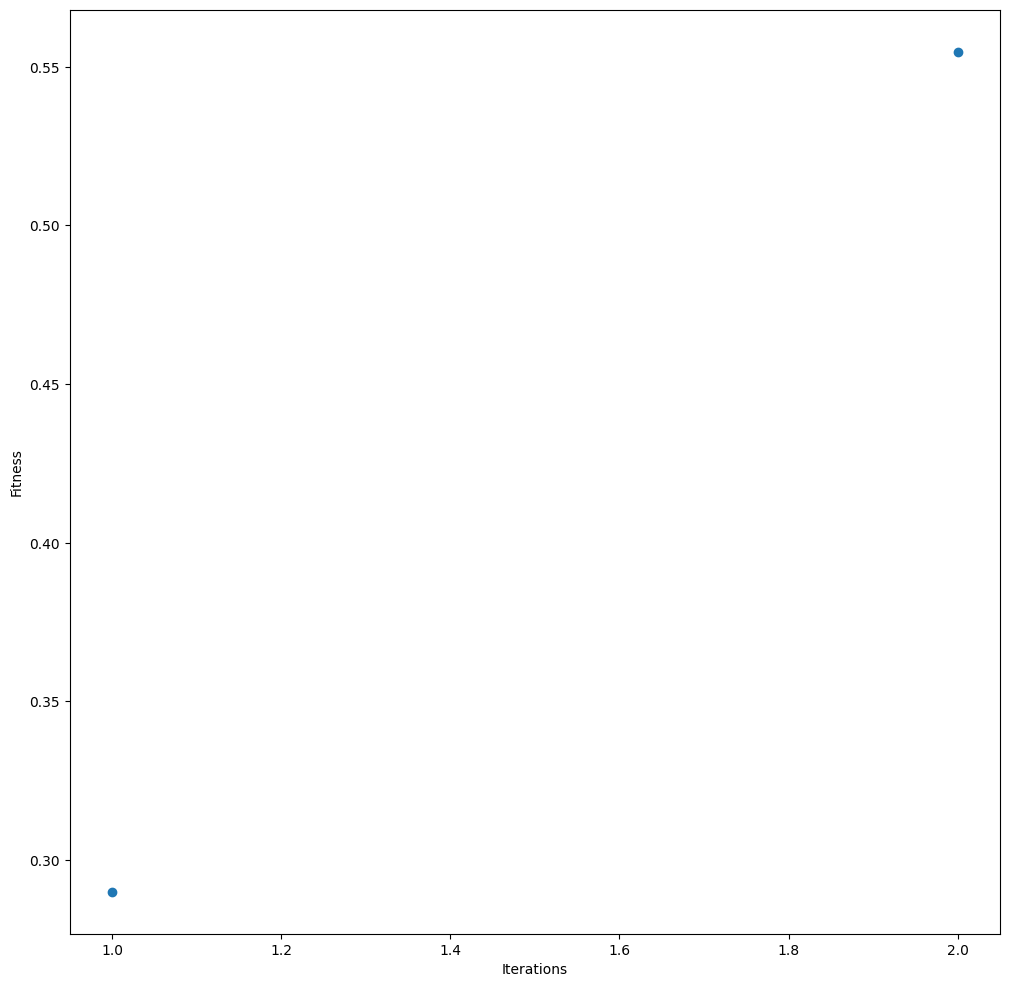

In [27]:
import matplotlib.pyplot as plt

fitness_deez = []

with open(f"{path}/log.jsonl") as f:
    lines = f.readlines()
    for line in lines:
        data = json.loads(line)
        fitness_deez.append(data["fitness"])
        # print(data["feedback"], "\n", data["error"])


plt.figure(figsize=(12,12))
plt.scatter(x=list(range(1, len(fitness_deez) + 1)), y=fitness_deez)
plt.xlabel("Iterations")
plt.ylabel("Fitness")

In [34]:
import pickle

class Bad:
    def __getstate__(self):
        raise TypeError("Can't pickle me")

data = {
    "bad" : Bad(),
    "a": 1,
    "b": [1, 2, Bad()],
    "c": {"x": "ok"}
}


def find_unpicklable(obj, path="root"):
    try:
        pickle.dumps(obj)
        return None  # This object is fine
    except Exception:
        if isinstance(obj, dict):
            for k, v in obj.items():
                bad = find_unpicklable(v, f"{path}[{k!r}]")
                if bad:
                    return bad
        elif isinstance(obj, (list, tuple, set)):
            for i, v in enumerate(obj):
                bad = find_unpicklable(v, f"{path}[{i}]")
                if bad:
                    return bad
        else:
            # It's a leaf object that failed
            return path
        return None





    if isinstance(obj, object):
        for k, v in obj.__dict__.items():
            try:
                pickle.dumps(v)
            except:
                return find_unpicklable(v, f"{path}[{k}]")
    return None

print(find_unpicklable(data))

root['bad']
